In [29]:
import sympy as sp

(1 - x0)**2 + 100*(-x0**2 + x1)**2

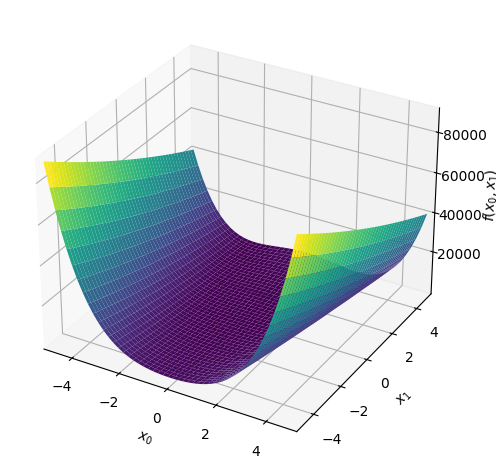

1


In [30]:
f = sp.Function('f')
variables = 2
x = sp.Matrix([0]*variables)
for i in range(variables):
    exec(f"x{i} = sp.symbols('x{i}')")
    x[i] = eval(f"x{i}")
#f = (x0**2 + x1**2)+sp.sin(x0)+sp.cos(x1)
f = (1-x0)**2 + 100*(x1-x0**2)**2
#f = (x0+2)**2 + (x1+2)**2
display(f)
# Plot the function
sp.plotting.plot3d(f, (x0, -5, 5), (x1, -5, 5))
# Lambda function
f_lambda = sp.lambdify(x, f, 'numpy')
fd_lambda = sp.lambdify(x, f.diff(x), 'numpy')
# Test the lambda function
print(f_lambda(0, 0))

In [31]:
xMax = sp.symbols('xMax')
xMin = sp.symbols('xMin')
maxConstraints = sp.Matrix([0]*variables)
minConstraints = sp.Matrix([0]*variables)
for i in range(variables):
    exec(f"maxConstraints[{i}] = xMax - x{i}")
    exec(f"minConstraints[{i}] = x{i} - xMin")
g = sp.Matrix([maxConstraints, minConstraints])
display(g)
print(g)

Matrix([
[-x0 + xMax],
[-x1 + xMax],
[ x0 - xMin],
[ x1 - xMin]])

Matrix([[-x0 + xMax], [-x1 + xMax], [x0 - xMin], [x1 - xMin]])


In [32]:
constraintsNum = len(g)
s = sp.Matrix([0]*constraintsNum)
l = sp.Matrix([0]*constraintsNum)
sln = sp.Matrix([0]*constraintsNum)
for i in range(constraintsNum):
    exec(f"s{i} = sp.symbols('s{i}')")
    s[i] = eval(f"s{i}")
    sln[i] = sp.ln(s[i])
    exec(f"l{i} = sp.symbols('l{i}')")
    l[i] = eval(f"l{i}")
mu = sp.symbols('mu')
# Unit vector
e = sp.Matrix([1]*constraintsNum)
lagrange = f - (mu * e.T * sln)[0] + ((g+s).T * l)[0]
display(lagrange)


l0*(s0 - x0 + xMax) + l1*(s1 - x1 + xMax) + l2*(s2 + x0 - xMin) + l3*(s3 + x1 - xMin) - mu*log(s0) - mu*log(s1) - mu*log(s2) - mu*log(s3) + (1 - x0)**2 + 100*(-x0**2 + x1)**2

In [33]:
# Compute the gradient of the lagrange function
grad = sp.Matrix([lagrange.diff(i) for i in x])
display(grad)
# Compute the hessian of the lagrange function
hess = sp.Matrix([[lagrange.diff(i1, i2) for i1 in x] for i2 in x])
display(hess)

Matrix([
[-l0 + l2 - 400*x0*(-x0**2 + x1) + 2*x0 - 2],
[             -l1 + l3 - 200*x0**2 + 200*x1]])

Matrix([
[2*(600*x0**2 - 200*x1 + 1), -400*x0],
[                   -400*x0,     200]])

In [34]:
# Compute jacobian of g
jacob = sp.Matrix([[g[i].diff(x[j]) for j in range(variables)] for i in range(constraintsNum)])
display(jacob)

Matrix([
[-1,  0],
[ 0, -1],
[ 1,  0],
[ 0,  1]])

In [35]:
# Diagonal matrix
S = sp.diag(*s)
Ep = sp.diag(*l)
I = sp.eye(constraintsNum)

In [36]:
A = sp.zeros(variables+constraintsNum*2, variables+constraintsNum*2)
A[:variables, :variables] = hess
A[:variables, variables:variables+constraintsNum] = jacob.T
A[variables:variables+constraintsNum, :variables] = jacob
A[variables:variables+constraintsNum, variables+constraintsNum:variables+constraintsNum*2] = sp.eye(constraintsNum)
A[variables+constraintsNum:variables+constraintsNum*2, variables:variables+constraintsNum] = sp.eye(constraintsNum)
A[variables+constraintsNum:variables+constraintsNum*2, variables+constraintsNum:variables+constraintsNum*2] = S.inv()*Ep

display(A)

Matrix([
[2*(600*x0**2 - 200*x1 + 1), -400*x0, -1,  0, 1, 0,     0,     0,     0,     0],
[                   -400*x0,     200,  0, -1, 0, 1,     0,     0,     0,     0],
[                        -1,       0,  0,  0, 0, 0,     1,     0,     0,     0],
[                         0,      -1,  0,  0, 0, 0,     0,     1,     0,     0],
[                         1,       0,  0,  0, 0, 0,     0,     0,     1,     0],
[                         0,       1,  0,  0, 0, 0,     0,     0,     0,     1],
[                         0,       0,  1,  0, 0, 0, l0/s0,     0,     0,     0],
[                         0,       0,  0,  1, 0, 0,     0, l1/s1,     0,     0],
[                         0,       0,  0,  0, 1, 0,     0,     0, l2/s2,     0],
[                         0,       0,  0,  0, 0, 1,     0,     0,     0, l3/s3]])

In [37]:
b = sp.zeros(variables+constraintsNum*2, 1)
b[:variables, 0] = grad
b[variables:variables+constraintsNum, 0] = g+s
b[variables+constraintsNum:variables+constraintsNum*2, 0] = l-mu*S.inv()*e
display(b)

Matrix([
[-l0 + l2 - 400*x0*(-x0**2 + x1) + 2*x0 - 2],
[             -l1 + l3 - 200*x0**2 + 200*x1],
[                            s0 - x0 + xMax],
[                            s1 - x1 + xMax],
[                            s2 + x0 - xMin],
[                            s3 + x1 - xMin],
[                                l0 - mu/s0],
[                                l1 - mu/s1],
[                                l2 - mu/s2],
[                                l3 - mu/s3]])

In [38]:
# Make A and b to functions
A_func = sp.lambdify([*x, *s, *l, mu, xMax, xMin], A)
b_func = sp.lambdify([*x, *s, *l, mu, xMax, xMin], b)

In [39]:
import numpy as np

In [40]:
# Test  
test_array = [1]*(variables+constraintsNum*2+3)
A_test = A_func(*test_array)
b_test = b_func(*test_array)
print(A_test)
print(b_test)

[[ 802. -400.   -1.    0.    1.    0.    0.    0.    0.    0.]
 [-400.  200.    0.   -1.    0.    1.    0.    0.    0.    0.]
 [  -1.    0.    0.    0.    0.    0.    1.    0.    0.    0.]
 [   0.   -1.    0.    0.    0.    0.    0.    1.    0.    0.]
 [   1.    0.    0.    0.    0.    0.    0.    0.    1.    0.]
 [   0.    1.    0.    0.    0.    0.    0.    0.    0.    1.]
 [   0.    0.    1.    0.    0.    0.    1.    0.    0.    0.]
 [   0.    0.    0.    1.    0.    0.    0.    1.    0.    0.]
 [   0.    0.    0.    0.    1.    0.    0.    0.    1.    0.]
 [   0.    0.    0.    0.    0.    1.    0.    0.    0.    1.]]
[[0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]]


In [43]:
def newtonSolver(initial, constraints, mu):
    x, s, l = initial[:variables], initial[variables:variables+constraintsNum], initial[variables+constraintsNum:]
    xMax, xMin = constraints
    state = np.concatenate([x, s, l, [mu, xMax, xMin]])
    A = A_func(*state)
    b = b_func(*state)
    A = np.array(A, dtype=float)
    b = np.array(b, dtype=float)
    step = np.linalg.solve(A, -b)
    return step, A, b

def IPM(x, constraints, max_iter=20, tol=1e-6):
    x = np.array(x, dtype=float)
    mu = 1.0
    tolCurrent = np.inf
    for i in range(max_iter):
        # Newton's method
        step, A, b = newtonSolver(x, constraints, mu)   
        
        # Max step size for design variables
        aMax = 1
        for j in range(constraintsNum):
            a = (0.005-1)*x[variables+constraintsNum+j]/step[variables+constraintsNum+j]
            if a > 0:
                aMax = min(aMax, a)
        aDesign = aMax

        # Line search
        ak = aMax
        cost = f_lambda(*x[:variables])
        newCost = f_lambda(*(x[:variables]+step.reshape(-1)[:variables]*ak))
        while newCost > cost + 1e-4*ak*(fd_lambda(*x[:variables]).T @ step[:variables]):
            ak *= 0.9
            newCost = f_lambda(*(x[:variables]+step.reshape(-1)[:variables]*ak))

        # Max step size for design variables
        aMax = 1
        for j in range(constraintsNum):
            a = (0.005-1)*x[variables+j]/step[variables+j]
            if a > 0:
                aMax = min(aMax, a)
        aLagrange = aMax

        # Update x
        step = step.reshape(-1)
        step[:variables] = step[:variables]*ak
        step[variables:variables+constraintsNum] = step[variables:variables+constraintsNum]*aLagrange
        step[variables+constraintsNum:] = step[variables+constraintsNum:]*ak
        x += step

        # Check convergence
        tolCurrent = np.linalg.norm(fd_lambda(*x[:variables]))
        print(f'Iteration {i+1}, tol = {np.round(tolCurrent, 3)}, mu = {np.round(mu, 2)}, ak = {ak}, al = {aLagrange} ad = {aDesign} \nx = {np.round(x, 2)}')
        if tolCurrent < tol:
            print('Converged')
            return x
        if ak < tol or aLagrange < tol:
            print('Line search failed')
            print(step)
            return x
        # Update mu
        mu *= 0.5
    return x

# design variables, lagrange multipliers, and slack variables
x = [*[5]*variables, *[1]*constraintsNum, *[0.01]*constraintsNum]
constraints = [-100, 100]
result = IPM(x, constraints)
print(np.round(result, 3))

Iteration 1, tol = 13.006, mu = 1.0, ak = 1, al = 1 ad = 1 
x = [  5.    24.98   0.95   0.75   1.05   1.25 104.01 123.99  94.01  74.03]
Iteration 2, tol = 332.719, mu = 0.5, ak = 0.06461081889226679, al = [8.63272149e-05] ad = 1 
x = [4.5200e+00 2.0290e+01 3.0000e-02 0.0000e+00 2.6000e-01 4.9000e-01
 1.1026e+02 1.2732e+02 1.0056e+02 8.3490e+01]
Iteration 3, tol = 35.734, mu = 0.25, ak = 0.16677181699666577, al = [8.78336621e-08] ad = 1 
x = [ -0.31   0.25   0.     0.     0.25   0.49 122.85 127.35 121.27 116.73]
Line search failed
[-4.83246809e+00 -2.00335370e+01 -2.69803258e-02 -4.73977565e-04
 -4.24470211e-03 -2.96226690e-03  1.25946433e+01  2.62145453e-02
  2.07120121e+01  3.32450208e+01]
[-3.09000e-01  2.53000e-01  0.00000e+00  3.00000e-03  2.55000e-01
  4.92000e-01  1.22851e+02  1.27349e+02  1.21268e+02  1.16735e+02]
